In [1]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=114640436 seed_offset=0 real_seed=114640436
core.init.random: RandomGenerator:i

In [2]:
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import math

In [3]:
def get_energy_landscape(pose, scorefxn, h = 5):
    
    N = int(360/h + 1)
    residues = pose.total_residue()
    Es = np.zeros((N,N))
    
    for res in range(0, residues):
        
        phis = np.arange(-180,180+h,h)
        psis = np.arange(-180,180+h,h)

    for i in range(0,len(phis)):
    
        phi = phis[i]
        pose.set_psi(1, phi)
    
        for j in range(0,len(psis)):
            psi = psis[j]
            pose.set_omega(1, psi)
            E = scorefxn(pose)
        
            Es[i,j] = E

    return Es, phis, psis

In [4]:
def numerical_hessian(Es, h = 5):
    
    N = int(360/h + 1)
    d2E_dphi2 = np.zeros((N,N))
    d2E_dpsi2 = np.zeros((N,N))
    d2E_dphidpsi = np.zeros((N,N))
    r = h*np.pi/180
    
    for i in range(0, len(phis)):

        for j in range(0, len(psis)):
        
            if j == 0:
            
                d2E_dpsi2[i,j] = (Es[i,N-1] - 2*Es[i,j] + Es[i,j+1])/r**2
            
            elif j == N-1:
            
                d2E_dpsi2[i,j] = (Es[i,j-1] - 2*Es[i,j] + Es[i,0])/r**2
        
            else:
            
                d2E_dpsi2[i,j] = (Es[i,j-1] - 2*Es[i,j] + Es[i,j+1])/r**2
        
    for j in range(0, len(phis)):

        for i in range(0, len(psis)):            
            if i == N-1:
            
                d2E_dphi2[i,j] = (Es[i-1,j] - 2*Es[i,j] + Es[0,j])/r**2
        
            else:
            
                d2E_dphi2[i,j] = (Es[i-1,j] - 2*Es[i,j] + Es[i+1,j])/r**2
            
    for i in range(0, len(phis)):
    
        for j in range(0, len(psis)):
        
            if j == 0:
            
                if i == 0:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,N-1] - Es[N-1,j+1] + Es[N-1,N-1]
            
                elif i == N-1:
                
                    d2E_dphidpsi[i,j] = Es[0,j+1] - Es[0,N-1] - Es[i-1,j+1] + Es[i-1,N-1]
                
                else:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,N-1] - Es[i-1,j+1] + Es[i-1,N-1]
                
            elif j == N-1:
            
                if i == 0:
                
                    d2E_dphidpsi[i,j] = Es[i+1,0] - Es[i+1,N-1] - Es[i-1,0] + Es[i-1,N-1]
            
                elif i == N-1:
                
                    d2E_dphidpsi[i,j] = Es[0,0] - Es[0,j-1] - Es[i-1,0] + Es[i-1,j-1]
                
                else:
                
                    d2E_dphidpsi[i,j] = Es[i+1,0] - Es[i+1,j-1] - Es[i-1,0] + Es[i-1,j-1]
                
            else:
            
                if i == 0:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,j-1] - Es[i-1,j+1] + Es[i-1,j-1]
                
                elif i == N-1:
                
                    d2E_dphidpsi[i,j] = Es[0,j+1] - Es[0,j-1] - Es[i-1,j+1] + Es[i-1,j-1]
                
                else:
                
                    d2E_dphidpsi[i,j] = Es[i+1,j+1] - Es[i+1,j-1] - Es[i-1,j+1] + Es[i-1,j-1]
                    
    return d2E_dphi2, d2E_dpsi2, d2E_dphidpsi/4/r**2
                

In [5]:
def find_minimum(pose, sf):
    
    minimum = Pose()
    total_residue = pose.total_residue()

    # Random starting config
    for i in range(1, total_residue+1):
        
        pose.set_psi(i, random.uniform(-180.0,180.0))
        pose.set_omega(i, random.uniform(-180.0,180.0))
    
    move_map = MoveMap()
    move_map.set(TorsionID(1, BB, 2), True)
    move_map.set(TorsionID(1, BB, 3), True)

    # Find local minimum
    min_mover = pyrosetta.rosetta.protocols.minimization_packing.MinMover()
    min_mover.score_function(sf)
    min_mover.movemap(move_map)
    min_mover.tolerance(1e-5)
    #min_mover.min_type('dfpmin_armijo_nonmonotone')
    min_mover.apply(pose)
    
    pose.set_psi(1, pose.psi(1)-360.0*round(pose.psi(1)/360.0))
    pose.set_omega(1, pose.omega(1)-360.0*round(pose.omega(1)/360.0))

    minimum.assign(pose)
    # print minimum.phi(1), minimum.psi(1)
    return minimum

In [7]:
def check_minimum(pose, phi_lists, psi_lists):
    
    phi_min = pose.psi(1)
    psi_min = pose.omega(1)
    
    for i in range(0, len(phi_lists)):
        
        phi_list = phi_lists[i]
        psi_list = psi_lists[i]
        
        if phi_min > phi_list[0] and phi_min < phi_list[1] and psi_min > psi_list[0] and psi_min < psi_list[1]:
            
            return True
        
    return False
    

In [8]:
def check_overlap(trial_phis, trial_psis, phi_list, psi_list):
    
    trial_phi_min = trial_phis[0]
    trial_phi_max = trial_phis[1]
    trial_psi_min = trial_psis[0]
    trial_psi_max = trial_psis[1]
        
    phi_min = phi_list[0]
    phi_max = phi_list[1]
    psi_min = psi_list[0]
    psi_max = psi_list[1]
    
    if trial_phi_min > phi_max or phi_min > trial_phi_max:
        return False
        
    if trial_psi_max < psi_min or psi_max < trial_psi_min:
        return False
 
    return True
    

In [89]:
def mode_scan(pose, sf, mode, K, kT = 1.0, h = 5.0):
    
    result = 0
    trial = Pose()
    inc = 0
    max_inc = int(60/h)
    
    E_0 = sf(pose)
    seed = Pose()
    seed.assign(pose)
    seed_energy = 0
    
    V = 1
    
    trial.assign(pose)
    #obs = pyrosetta.rosetta.protocols.moves.AddPyMOLObserver(trial, True)
    trial_energy = sf(pose)
    cutoff = 0.2
    
    phi = pose.psi(1)
    psi = pose.omega(1)
    
    # deform along positive direction
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(trial_energy-E_0)/kT)
        
        trial.set_psi(1, trial.psi(1) - mode[0]*h)
        trial.set_omega(1, trial.omega(1) - mode[1]*h)
        
        seed_energy = sf(trial)
        if abs(seed_energy-E_0) > cutoff or seed_energy < E_0:
            break
            
        if seed_energy < trial_energy:
            
            seed.assign(trial)
            
        trial_energy = seed_energy 
        result += 0.5*np.exp(-(trial_energy-E_0)/kT)

    phi_min = trial.psi(1)
    psi_min = trial.omega(1)
    
    trial.assign(pose)
    trial_energy = sf(pose)
    
    inc = 0
    
    # deform along opposite direction
    while inc < max_inc:
        
        inc +=1 
        
        result += 0.5*np.exp(-(trial_energy-E_0)/kT)
        
        trial.set_psi(1, trial.psi(1) + mode[0]*h)
        trial.set_omega(1, trial.omega(1) + mode[1]*h)
        
        seed_energy = sf(trial)
        if abs(seed_energy-E_0) > cutoff or seed_energy < E_0:
            break
            
        if seed_energy < sf(seed):
            
            seed.assign(trial)
                
        trial_energy = seed_energy 
        result += 0.5*np.exp(-(trial_energy-E_0)/kT)
        
    result *= h*np.pi/180
    phi_max = trial.psi(1)
    psi_max = trial.omega(1)
    #seed.assign(trial)
    V = abs(phi_min-phi_max)*abs(psi_min-psi_max)*np.pi**2/180.0/180.0
    
    #A = -np.log(V*result)
    
    return result, V, seed
            
        

In [30]:
def harmonic_integral(K, kT):
    
    return

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.import_pose.import_pose: File 'alanine-dipeptide-implicit.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom 1HH3 as 1HP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  CH3 as  CP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom 2HH3 as 2HP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom 3HH3 as 3HP2
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  C   as  CO
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  O   as  OP1
core.io.pose_from_sfr.PoseFromSFRBuilder: Renaming atom  N   as  NM
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 4 atoms at position 2 in file alanine-dipeptide-implicit.pdb. Best match rsd_type:  ALA:MethylatedCtermProteinFull:AcetylatedNtermProteinFull
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CN  on residue ALA:MethylatedCtermProteinFull:AcetylatedNtermProteinFull 1
core

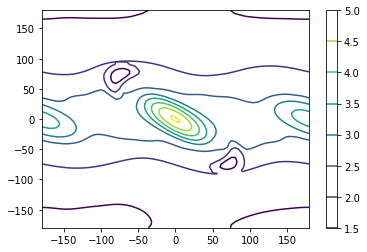

In [104]:
import scipy.interpolate
import matplotlib
import matplotlib.pyplot as plt

scorefxn = get_fa_scorefxn()
pose = pose_from_pdb('alanine-dipeptide-implicit.pdb')

h = 5
energy, phis, psis = get_energy_landscape(pose, scorefxn, h)
d2E_dphi2, d2E_dpsi2, d2E_dphidpsi = numerical_hessian(energy, h)

dphi2_fxn = scipy.interpolate.RectBivariateSpline(phis, psis, d2E_dphi2)
dpsi2_fxn = scipy.interpolate.RectBivariateSpline(phis, psis, d2E_dpsi2)
dphidpsi_fxn = scipy.interpolate.RectBivariateSpline(phis, psis, d2E_dphidpsi)

plt.contour(phis, psis, energy)
plt.colorbar()

In [ ]:
from pyrosetta.rosetta.core.id import *

energies = np.zeros((2, 100))

for foo in range(0, 100):

    ind = 0
    count = 0
    count_new = count

    minima = []
    phi_lists = []
    psi_lists = []
    A = 0
    Z = 1
    V = 1
    A_old = A
    V_tot = (2*np.pi)**2
    V_sampled = 0

    seed = Pose()

    while True and ind < 15000:

        ind +=1
        Z = 1
        minimum = Pose()

        if seed:

            move_map = MoveMap()
            move_map.set(TorsionID(1, BB, 2), True)
            move_map.set(TorsionID(1, BB, 3), True)

            # Find local minimum
            min_mover = pyrosetta.rosetta.protocols.minimization_packing.MinMover()
            min_mover.score_function(scorefxn)
            min_mover.movemap(move_map)
            #min_mover.min_type('dfpmin_armijo_nonmonotone')
            seed.set_psi(1, seed.psi(1)+random.uniform(-30,30))
            seed.set_omega(1, seed.omega(1)+random.uniform(-30,30))
            min_mover.apply(seed)

            seed.set_psi(1, seed.psi(1)-360.0*round(seed.psi(1)/360.0))
            seed.set_omega(1, seed.omega(1)-360.0*round(seed.omega(1)/360.0))

            minimum.assign(seed)
            seed = Pose()

        else:

            minimum.assign(find_minimum(pose, scorefxn))

        phi = minimum.psi(1)
        psi = minimum.omega(1)

        minima.append(minimum)


        # Check that minimum isn't in well already found
        if len(minima) > 1 and check_minimum(minimum, phi_lists, psi_lists):
            minima.pop()
            continue
        
        
        phi_min = max(phi-60, -180)
        phi_max = min(phi+60, 180)
        psi_min = max(psi-60, -180)
        psi_max = min(psi+60, 180)
        
        phi_list = [phi_min, phi_max]
        psi_list = [psi_min, psi_max]
        
        phi_lists.append(phi_list)
        psi_lists.append(psi_list)
        
        # Check that old minimum hasn't been found again 
        if len(minima) > 1:

            for i in range(0, len(minima)-1):

                if check_overlap(phi_list, psi_list, phi_lists[i], psi_lists[i]):


                    count_new += 1
                    minima.pop()

                    phi_lists.pop()
                    psi_lists.pop()

                    break

        if count_new > count:

            count = count_new

            continue

        hess = np.zeros((2,2))

        # Calculate hessian at base of well
        hess[0,0] = dphi2_fxn(phi, psi)
        hess[0,1] = dphidpsi_fxn(phi, psi)
        hess[1,0] = hess[0,1]
        hess[1,1] = dpsi2_fxn(phi, psi)

        # Diagonalization of hessian
        w, v = scipy.linalg.eigh(hess)

        # Discard wells with non-positive definite hessian 
        if w[0]*w[1] < 0 or (w[0] < 0 and w[1] < 0):
            minima.pop()
            phi_lists.pop()
            psi_lists.pop()
            continue

        print phi, psi
        from scipy.special import erf
        for i in range(0,len(w)):

            K = w[i]

            # Mode scan for soft degrees of freedom
            if K < 10.0:

                Z_j, V_j, seed = mode_scan(minimum, scorefxn, v[:,i], K, 1.0, 0.5)
                sig = np.sqrt(1.0/K)
                interval = min(2*sig, np.pi/3)         
                Z *= Z_j

                print Z

            # Harmonic integration
            else:

                sig = np.sqrt(1.0/K)
                interval = min(3*sig, np.pi/3)         
                Z *= np.sqrt(2*np.pi)*sig*scipy.special.erf(interval/np.sqrt(2/K))

        A += Z
        Z = 1
            
        V_sampled += abs(phi_list[1]-phi_list[0])*abs(psi_list[1]-psi_list[0])*np.pi**2/180/180
        print w
        print phi_list, psi_list
        print -np.log(A)
        print len(minima)

        # check convergence criterion
        if abs(A_old-A)/A_old < 0.001:
            
            break
            
        A_old = A

    print -np.log(A)
    
    energies[0, foo] = len(minima)
    energies[1, foo] = -np.log(A)

In [91]:
import matplotlib as mpl
import matplotlib.pyplot as plt

Text(0,0.5,'Count')

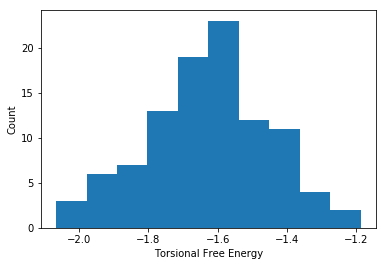

In [92]:
plt.hist(energies[1,:], 10)
plt.xlabel('Torsional Free Energy')
plt.ylabel('Count')

In [93]:
print np.mean(energies[1,:]), np.std(energies)

-1.62582872731 4.27309345874


[[ 7.          7.          7.          7.          7.          7.          7.
   7.          7.          7.          7.          7.          7.          7.
   7.          7.          7.          7.          7.          7.          7.
   7.          7.          7.          7.          7.          7.          7.
   7.          7.          7.          7.          7.          7.          7.
   7.          7.          7.          7.          7.          7.          7.
   7.          7.        ]
 [-1.55165912 -1.53939631 -1.56420911 -1.48160061 -1.61835336 -1.8526572
  -1.64921338 -1.69128307 -1.77952376 -1.54141712 -1.60011847 -1.72493718
  -1.78480317 -1.90721709 -1.61045099 -1.64441994 -1.56636994 -1.73518944
  -1.73520494 -1.6476336  -1.85536189 -1.6431259  -1.65314049 -1.7019795
  -1.63773089 -1.71147695 -1.65193501 -1.65845555 -1.53318158 -1.64675978
  -1.72756869 -1.74419156 -1.55514578 -1.61130928 -1.54460379 -1.51938739
  -1.62036756 -1.50423042 -1.58715137 -1.75758267 -1.66963349 -

(array([  3.,   2.,   1.,   3.,   6.,   4.,  11.,   3.,   8.,   3.]),
 array([-1.90960828, -1.86680752, -1.82400675, -1.78120598, -1.73840521,
        -1.69560445, -1.65280368, -1.61000291, -1.56720214, -1.52440138,
        -1.48160061]),
 <a list of 10 Patch objects>)

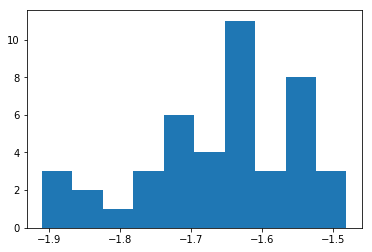

In [100]:
b = energies[0,:] == 7
indices = np.stack((b,b))
sampled_energies = energies[indices]
sampled_energies = sampled_energies.reshape((2,len(sampled_energies)/2))
print sampled_energies
plt.hist(sampled_energies[1,:], 10)

In [101]:
print np.average(sampled_energies[1,:]), np.std(sampled_energies[1,:])

-1.66294659417 0.108949521552
